In [76]:
# System modules
import os
import sys
from dotenv import load_dotenv
import logging
import requests
from hashlib import md5
import json

# ML modules
import pandas as pd
import numpy as np

# Viz modules
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



# Append source directory to system path
src_path = os.path.abspath(os.path.join("../src"))
if src_path not in sys.path:
    sys.path.append(src_path)

# Helper functions
import data.helpers as data_helpers
import visualization.helpers as viz_helpers


load_dotenv()  # take environment variables from .env.

YELP_CLIENT_ID = os.getenv("YELP_CLIENT_ID")
YELP_API_KEY = os.getenv("YELP_API_KEY")


In [77]:
def yelp_business_search_by_location(
    location: str = "Paris", count: int = 200
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    Params:
        location: str
        count: int

    Returns:
        json
    """
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
    }
    limit = 50

    businesses = pd.DataFrame()
    reviews = pd.DataFrame()
    photos = pd.DataFrame()
    for offset in range(0, count, limit):
        businesses_request = requests.get(
            "https://api.yelp.com/v3/businesses/search",
            headers=headers,
            params={
                "location": location,
                "limit": limit,
                "offset": offset,
            },
        )

        if businesses_request.status_code == 200:
            businesses_data = businesses_request.json()
            businesses = businesses.append(
                pd.DataFrame(businesses_data["businesses"]), ignore_index=True
            )

            for business in businesses_data["businesses"]:
                business_detail_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}",
                    headers=headers,
                )
                if business_detail_request.status_code == 200:
                    business_detail_data = business_detail_request.json()
                    photos = photos.append(
                        pd.DataFrame(business_detail_data["photos"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code \
                             { business_detail_request.status_code }. \
                                 Response text: { business_detail_request.text }"
                    )

            for business in businesses_data["businesses"]:
                business_reviews_request = requests.get(
                    f"https://api.yelp.com/v3/businesses/{business['id']}/reviews",
                    headers=headers,
                )
                if business_reviews_request.status_code == 200:
                    business_reviews_data = business_reviews_request.json()
                    reviews = reviews.append(
                        pd.DataFrame(business_reviews_data["reviews"]),
                        ignore_index=True,
                    )
                else:
                    raise Exception(
                        f"Yelp API request failed with status code { business_reviews_request.status_code }. Response text: { business_reviews_request.text }"
                    )

        else:
            raise Exception(
                f"Yelp API request failed with status code { businesses_request.status_code }. Response text: { businesses_request.text }"
            )

    return businesses, reviews, photos


In [78]:
def get_yelp_data(
    locations: list[str] = [
        "Paris",
        "New York City",
        "Tokyo",
        "Rio de Janeiro",
        "Sydney",
    ],
    category: str = "restaurants",
) -> tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Get Yelp data from API.

    - iterate over the locations
        - build a GraphQL query to get the data
        - send the query to the Yelp API
        - parse the response
        - append to the dataframe
    - return the dataframes

    Params:
        locations: str[] (default: ["Paris"]) - List of Yelp locations to search
        category: str (default: "restaurants") - Yelp category (see https://www.yelp.com/developers/documentation/v3/all_category_list)

    Returns:
        businesses: pd.DataFrame - businesses data from Yelp API request
        reviews: pd.DataFrame - reviews data from Yelp API request
        photos: pd.DataFrame - photos data from Yelp API request
    """
    # businesses data (see https://www.yelp.com/developers/graphql/objects/business)
    businesses = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of this business.
            "business_review_count",  # Total number of reviews for this business.
            "business_rating",  # Rating of the business, which is an average of the ratings of all reviews.
            "business_price",  # Price range of the business, from "$" to "$$$$" (inclusive).
            "business_city",  # City of this business.
            "business_state",  # ISO 3166-2 (with a few exceptions) state code of this business (see https://www.yelp.com/developers/documentation/v3/state_codes).
            "business_postal_code",  # Postal code of this business (see https://en.wikipedia.org/wiki/Postal_code)
            "business_country",  # ISO 3166-1 alpha-2 country code of this business.
            "business_latitude",  # Latitude of the business.
            "business_longitude",  # Longitude of the business.
            "business_categories",  # List of categories the business belongs to.
            "business_parent_categories",  # List of parent categories the business belongs to.
        ]
    )
    reviews = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "review_text",  # Text excerpt of this review.
            "review_rating",  # Rating of this review.
        ]
    )
    photos = pd.DataFrame(
        columns=[
            "business_alias",  # Unique Yelp alias of the business.
            "photo_url",  # URL of the photo.
        ]
    )

    # Yelp's GraphQL endpoint
    url = "https://api.yelp.com/v3/graphql"
    # Request headers
    headers = {
        "Authorization": f"Bearer {YELP_API_KEY}",
        "Content-Type": "application/graphql",
    }
    count = 200  # Yelp's GraphQL API returns a maximum of 240 total results
    limit = 50  # Yelp's GraphQL API returns a maximum of 50 results per request

    for location in locations:
        for offset in range(0, count, limit):
            # Build the GraphQL query
            query = f'{{\n\
        search(categories: "{ category }", location: "{ location }", offset: { offset }, limit:  { limit }) {{\n\
            business {{\n\
                alias\n\
                review_count\n\
                rating\n\
                price\n\
                location {{\n\
                    city\n\
                    state\n\
                    postal_code\n\
                    country\n\
                }}\n\
                coordinates {{\n\
                    latitude\n\
                    longitude\n\
                }}\n\
                categories {{\n\
                    alias\n\
                    parent_categories {{\n\
                        alias\n\
                    }}\n\
                }}\n\
                photos\n\
                reviews {{\n\
                    text\n\
                    rating\n\
                }}\n\
            }}\n\
        }}\n\
    }}'
            # Send the query to the Yelp API
            response = requests.post(url, headers=headers, data=query)
            # Parse the response
            if not response.status_code == 200:
                raise Exception(
                    f"Yelp API request failed with status code { response.status_code }. Response text: { response.text }"
                )

            # Parse the response
            data = response.json()

            if "errors" in data:
                raise Exception(
                    f"Yelp API request failed with errors: { data['errors'] }"
                )

            for business in (
                data.get("data", {}).get("search", {}).get("business", [])
            ):
                # Add the business data to the dataframe
                businesses = businesses.append(
                    {
                        "business_alias": business.get("alias"),
                        "business_review_count": business.get("review_count"),
                        "business_rating": business.get("rating"),
                        "business_price": len(  # count the number of characters ($, €, ...)
                            business.get("price")
                        )
                        if business.get("price") is not None
                        else 0,
                        "business_city": business.get("location", {}).get(
                            "city"
                        ),
                        "business_state": business.get("location", {}).get(
                            "state"
                        ),
                        "business_postal_code": business.get(
                            "location", {}
                        ).get("postal_code"),
                        "business_country": business.get("location", {}).get(
                            "country"
                        ),
                        "business_latitude": business.get(
                            "coordinates", {}
                        ).get("latitude"),
                        "business_longitude": business.get(
                            "coordinates", {}
                        ).get("longitude"),
                        "business_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                        "business_parent_categories": json.dumps(
                            list(
                                set(  # keep unique values
                                    [
                                        parent_cat.get("alias")
                                        for cat in business.get(
                                            "categories", []
                                        )
                                        for parent_cat in cat.get(
                                            "parent_categories", []
                                        )
                                    ]
                                )
                            )
                        ),
                    },
                    ignore_index=True,
                )

                for photo in business.get("photos", []) or []:
                    # Add the photo data to the dataframe
                    photos = photos.append(
                        {
                            "business_alias": business.get("alias"),
                            "photo_url": photo,
                            "file_name": f"{ business.get('alias') }_{ md5(photo.encode('utf-8')).hexdigest() }.jpg",
                        },
                        ignore_index=True,
                    )

                for review in business.get("reviews", []) or []:
                    # Add the review data to the dataframe
                    reviews = reviews.append(
                        {
                            "business_alias": business.get("alias"),
                            "review_text": review.get("text"),
                            "review_rating": review.get("rating"),
                        },
                        ignore_index=True,
                    )

    # Return the dataframes
    return businesses, reviews, photos


def download_photos(
    photos: pd.DataFrame,
    target_path: str,
) -> None:
    # Check if content path exists
    if not os.path.exists(target_path):
        logging.info(f"Creating {target_path}")
        os.makedirs(target_path)

    for photo in photos.itertuples(index=False):
        file_path = os.path.join(target_path, photo.file_name)

        if not os.path.exists(file_path):
            request = requests.get(photo.photo_url)
            if not 200 == request.status_code:
                logging.warning(
                    f"Photo URL : { photo.photo_url }\nYelp API request failed with status code: { request.status_code }.\nResponse text: { request.text }"
                )
                continue

            photo_data = request.content
            with open(file_path, "wb") as f:
                f.write(photo_data)


In [79]:
data_path = "../data/raw/"
businesses_csv_path = os.path.join(data_path, "businesses.csv")
reviews_csv_path = os.path.join(data_path, "reviews.csv")
photos_csv_path = os.path.join(data_path, "photos.csv")

if not os.path.exists(data_path):
    logging.info(f"Creating {data_path}")
    os.makedirs(data_path)

if (
    os.path.exists(businesses_csv_path)
    and os.path.exists(reviews_csv_path)
    and os.path.exists(photos_csv_path)
):
    logging.info(f"Data already downloaded")
    businesses_df = pd.read_csv(businesses_csv_path)
    reviews_df = pd.read_csv(reviews_csv_path)
    photos_df = pd.read_csv(photos_csv_path)
else:
    logging.info("Saving data")
    businesses_df, reviews_df, photos_df = get_yelp_data()

    businesses_df.to_csv(businesses_csv_path, index=False)
    reviews_df.to_csv(reviews_csv_path, index=False)
    photos_df.to_csv(photos_csv_path, index=False)


# Fix dtypes
businesses_df["business_alias"] = businesses_df["business_alias"].astype(str)
businesses_df["business_review_count"] = businesses_df[
    "business_review_count"
].astype(int)
businesses_df["business_rating"] = businesses_df["business_rating"].astype(
    float
)
businesses_df["business_price"] = businesses_df["business_price"].astype(int)
businesses_df["business_city"] = businesses_df["business_city"].astype(str)
businesses_df["business_state"] = businesses_df["business_state"].astype(str)
businesses_df["business_postal_code"] = businesses_df[
    "business_postal_code"
].astype(str)
businesses_df["business_country"] = businesses_df["business_country"].astype(
    str
)
businesses_df["business_latitude"] = businesses_df["business_latitude"].astype(
    float
)
businesses_df["business_longitude"] = businesses_df[
    "business_longitude"
].astype(float)
businesses_df["business_categories"] = businesses_df[
    "business_categories"
].astype(str)
businesses_df["business_parent_categories"] = businesses_df[
    "business_parent_categories"
].astype(str)

reviews_df["business_alias"] = reviews_df["business_alias"].astype(str)
reviews_df["review_text"] = reviews_df["review_text"].astype(str)
reviews_df["review_rating"] = reviews_df["review_rating"].astype(float)

photos_df["business_alias"] = photos_df["business_alias"].astype(str)
photos_df["photo_url"] = photos_df["photo_url"].astype(str)
photos_df["file_name"] = photos_df["file_name"].astype(str)


# Reduce memory usage
businesses_df = data_helpers.reduce_dataframe_memory_usage(businesses_df)
reviews_df = data_helpers.reduce_dataframe_memory_usage(reviews_df)
photos_df = data_helpers.reduce_dataframe_memory_usage(photos_df)


In [80]:
businesses_df.head()


business_alias  business_review_count  \
0  le-comptoir-de-la-gastronomie-paris                   1107   
1               l-as-du-fallafel-paris                   1810   
2                       angelina-paris                   1347   
3             l-avant-comptoir-paris-3                    612   
4               la-coïncidence-paris-4                    493   

   business_rating  business_price business_city business_state  \
0              4.5               2         Paris             75   
1              4.5               1         Paris             75   
2              4.0               3         Paris             75   
3              4.5               2         Paris             75   
4              4.5               2         Paris             75   

  business_postal_code business_country  business_latitude  \
0                75001               FR          48.864517   
1                75004               FR          48.857498   
2                75001               FR          48.865093   
3                75006               FR          48.852020   
4                75116               FR          48.868107   

   business_longitude                      business_categories  \
0            2.345402                               ["french"]   
1            2.359080      ["kosher", "falafel", "sandwiches"]   
2            2.328464  ["tea", "cakeshop", "breakfast_brunch"]   
3            2.338800                   ["wine_bars", "tapas"]   
4            2.284365                               ["french"]   

         business_parent_categories  
0                   ["restaurants"]  
1  ["restaurants", "mediterranean"]  
2           ["restaurants", "food"]  
3           ["bars", "restaurants"]  
4                   ["restaurants"]

In [81]:
businesses_df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude business_categories business_parent_categories  
count          1000.000000                1000                       1000  
unique                 NaN                 530                         50  
top                    NaN          ["french"]            ["restaurants"]  
freq                   NaN                  56                        551  
mean             35.219700                 NaN                        NaN  
std              93.358452                 NaN                        NaN  
min             -74.016022                 NaN                        NaN  
25%             -43.218462                 NaN                        NaN  
50%               2.340317                 NaN                        NaN  
75%             139.770420                 NaN                        NaN  
max             151.298248                 NaN                        NaN

In [82]:
reviews_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1  le-comptoir-de-la-gastronomie-paris   
2  le-comptoir-de-la-gastronomie-paris   
3               l-as-du-fallafel-paris   
4               l-as-du-fallafel-paris   

                                         review_text  review_rating  
0  This review is from our 2019 trip.  Shame on m...            5.0  
1  This place def lives up the hype.  Best French...            5.0  
2  While planning a friends trip to Paris, I came...            5.0  
3  This is the best falafel sandwich I have ever ...            5.0  
4  IMO this is a must try in Paris. 

Located in ...            5.0

In [83]:
reviews_df.describe(include="all")


business_alias  \
count                                  2928   
unique                                  990   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      3   
mean                                    NaN   
std                                     NaN   
min                                     NaN   
25%                                     NaN   
50%                                     NaN   
75%                                     NaN   
max                                     NaN   

                                              review_text  review_rating  
count                                                2928    2928.000000  
unique                                               2928            NaN  
top     This review is from our 2019 trip.  Shame on m...            NaN  
freq                                                    1            NaN  
mean                                                  NaN       4.396516  
std                                                   NaN       0.904879  
min                                                   NaN       1.000000  
25%                                                   NaN       4.000000  
50%                                                   NaN       5.000000  
75%                                                   NaN       5.000000  
max                                                   NaN       5.000000

In [84]:
photos_df.head()


business_alias  \
0  le-comptoir-de-la-gastronomie-paris   
1               l-as-du-fallafel-paris   
2                       angelina-paris   
3             l-avant-comptoir-paris-3   
4               la-coïncidence-paris-4   

                                           photo_url  \
0  https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
1  https://s3-media2.fl.yelpcdn.com/bphoto/wdIhzK...   
2  https://s3-media3.fl.yelpcdn.com/bphoto/DPM5TB...   
3  https://s3-media3.fl.yelpcdn.com/bphoto/mVwgxg...   
4  https://s3-media1.fl.yelpcdn.com/bphoto/QdrAgE...   

                                           file_name  
0  le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
1  l-as-du-fallafel-paris_ab3344d5839c2238e825b28...  
2  angelina-paris_0aced3805db4ea7246d49c771fc48d8...  
3  l-avant-comptoir-paris-3_73670e8469e59d89b41bf...  
4  la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb...

In [85]:
photos_df.describe(include="all")


business_alias  \
count                                   999   
unique                                  999   
top     le-comptoir-de-la-gastronomie-paris   
freq                                      1   

                                                photo_url  \
count                                                 999   
unique                                                999   
top     https://s3-media2.fl.yelpcdn.com/bphoto/Je6THJ...   
freq                                                    1   

                                                file_name  
count                                                 999  
unique                                                999  
top     le-comptoir-de-la-gastronomie-paris_0200c0c54c...  
freq                                                    1

In [86]:
download_photos(photos_df, target_path="../data/raw/photos/")


In [13]:
def one_hot_encode_list_variables(
    df: pd.DataFrame,
    columns: list[str],
) -> pd.DataFrame:
    """One-hot encode list variables.
    See : https://cmpoi.medium.com/a-quick-tutorial-to-encode-list-variables-125ba4040325

    - for each list variable
        - decode JSON values to list
        - make a dataframe of one-hot encoded values
        - append to original dataframe

    Args:
        df (pd.DataFrame): dataframe to encode
        columns (list[str]): list of columns to encode

    Raises:
        Exception: columns values should be (JSON encoded) lists of strings

    Returns:
        pd.DataFrame:  dataframe with encoded columns
    """
    df = df.copy()
    for col in columns:
        if not isinstance(df[col][0], list):
            df[col] = df[col].replace(
                "[]", "null"
            )  # replace empty list with null
            df[col] = df[col].apply(json.loads)  # convert string to list

        if not isinstance(df[col][0], list):
            raise Exception(f"{col} is not a list")

        categories_df = (
            pd.get_dummies(
                pd.DataFrame(
                    [
                        x
                        if x is not None
                        else ["__EMPTY__"]  # replace None with empty list
                        for x in df[col].tolist()
                    ]
                ).stack(),
            )
            .groupby(level=0)
            .sum()
        ).drop(
            columns="__EMPTY__", errors="ignore"
        )  # remove empty list

        df = pd.concat([df, categories_df], axis=1)

    return df


df = one_hot_encode_list_variables(
    businesses_df, ["business_categories", "business_parent_categories"]
)


In [14]:
df.describe(include="all")


business_alias  business_review_count  \
count                                  1000            1000.000000   
unique                                 1000                    NaN   
top     le-comptoir-de-la-gastronomie-paris                    NaN   
freq                                      1                    NaN   
mean                                    NaN             529.395000   
std                                     NaN            1134.869631   
min                                     NaN               6.000000   
25%                                     NaN              30.000000   
50%                                     NaN              71.000000   
75%                                     NaN             265.750000   
max                                     NaN           13047.000000   

        business_rating  business_price business_city business_state  \
count       1000.000000     1000.000000          1000           1000   
unique              NaN             NaN            40              6   
top                 NaN             NaN         Paris             13   
freq                NaN             NaN           200            200   
mean           4.270500        2.144000           NaN            NaN   
std            0.353135        0.897814           NaN            NaN   
min            3.000000        0.000000           NaN            NaN   
25%            4.000000        2.000000           NaN            NaN   
50%            4.500000        2.000000           NaN            NaN   
75%            4.500000        3.000000           NaN            NaN   
max            5.000000        4.000000           NaN            NaN   

       business_postal_code business_country  business_latitude  \
count                  1000             1000        1000.000000   
unique                  301                5                NaN   
top                    2000               AU                NaN   
freq                    139              200                NaN   
mean                    NaN              NaN          13.688472   
std                     NaN              NaN          34.823799   
min                     NaN              NaN         -33.897026   
25%                     NaN              NaN         -22.983292   
50%                     NaN              NaN          35.673141   
75%                     NaN              NaN          40.751259   
max                     NaN              NaN          48.890209   

        business_longitude  ...     jpsweets        latin        media  \
count          1000.000000  ...  1000.000000  1000.000000  1000.000000   
unique                 NaN  ...          NaN          NaN          NaN   
top                    NaN  ...          NaN          NaN          NaN   
freq                   NaN  ...          NaN          NaN          NaN   
mean             35.219700  ...     0.001000     0.001000     0.003000   
std              93.358452  ...     0.031623     0.031623     0.054717   
min             -74.016022  ...     0.000000     0.000000     0.000000   
25%             -43.218462  ...     0.000000     0.000000     0.000000   
50%               2.340317  ...     0.000000     0.000000     0.000000   
75%             139.770420  ...     0.000000     0.000000     0.000000   
max             151.298248  ...     1.000000     1.000000     1.000000   

        mediterranean      mexican   mideastern    nightlife  \
count     1000.000000  1000.000000  1000.000000  1000.000000   
unique            NaN          NaN          NaN          NaN   
top               NaN          NaN          NaN          NaN   
freq              NaN          NaN          NaN          NaN   
mean         0.003000     0.004000     0.003000     0.060000   
std          0.054717     0.063151     0.054717     0.237606   
min          0.000000     0.000000     0.000000     0.000000   
25%          0.000000     0.000000     0.000000     0.000000   
50%          0.000000     0.000000     0.000000     0

## Commentaires clients


In [15]:
fig = px.histogram(reviews_df, x="review_rating", marginal="box")
fig.show()


In [67]:
from sklearn.model_selection import train_test_split


X = reviews_df["review_text"]
y = reviews_df["review_rating"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Sentiment analysis : binary classification
y_bi = [0 if x < 5 else 1 for x in y]
y_train_bi = [0 if x < 5 else 1 for x in y_train]
y_test_bi = [0 if x < 5 else 1 for x in y_test]


In [68]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
import spacy

nltk.download("stopwords")
nltk.download("wordnet")
stopwords = set(stopwords.words("english"))

nlp = spacy.load("en_core_web_sm")


def pos_tagger(nltk_tag):
    if nltk_tag.startswith("J"):
        return wordnet.ADJ
    elif nltk_tag.startswith("V"):
        return wordnet.VERB
    elif nltk_tag.startswith("N"):
        return wordnet.NOUN
    elif nltk_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN


tokenizers = {
    "None": None,
    "stopwords": lambda text: [
        token.lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "PorterStemmer": lambda text: [
        PorterStemmer().stem(token).lower()
        for token in word_tokenize(text)
        if token.isalpha() and token.lower() not in stopwords
    ],
    "WordNetLemmatizer": lambda text: [
        WordNetLemmatizer().lemmatize(token, pos_tagger(pos)).lower()
        for token, pos in pos_tag(word_tokenize(text))
        if token.isalpha() and token.lower() not in stopwords
    ],
    "SpaCy": lambda text: [
        token.lemma_.lower()
        for token in nlp(text)
        if token.is_alpha and not token.is_stop
    ],
}


vectorizers = {
    "CountVectorizer": CountVectorizer(),
    "TfidfVectorizer": TfidfVectorizer(),
    "CountVectorizer + strip_accents + lowercase": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "TfidfVectorizer + strip_accents + lowercase": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
    ),
    "CountVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
    "TfidfVectorizer + strip_accents + lowercase + stop_words + {min,max}_df + ngrams": TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        stop_words=stopwords,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
    ),
}

for tokenizer_name, tokenizer in tokenizers.items():
    vectorizers[
        f"CountVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = CountVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )
    vectorizers[
        f"TfidfVectorizer + strip_accents + lowercase + {{min,max}}_df + ngrams + {tokenizer_name}"
    ] = TfidfVectorizer(
        strip_accents="unicode",
        lowercase=True,
        max_df=0.9,
        min_df=0.01,
        ngram_range=(1, 3),
        tokenizer=tokenizer,
    )


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/clement/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/clement/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [69]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import (
    LinearRegression,
    BayesianRidge,
    PassiveAggressiveRegressor,
    SGDRegressor,
    Ridge,
    RidgeCV,
    Lars,
    LarsCV,
    Lasso,
    LassoCV,
    ElasticNet,
    ElasticNetCV,
    LassoLars,
    LassoLarsCV,
    OrthogonalMatchingPursuit,
    OrthogonalMatchingPursuitCV,
    BayesianRidge,
    ARDRegression,
    HuberRegressor,
    TheilSenRegressor,
    PassiveAggressiveRegressor,
    SGDRegressor,
)
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor


# Regression
if not os.path.exists("../results/regressors_grid_search_results.csv"):
    pipe_reg = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("reg", DummyRegressor()),
        ]
    )
    grid_reg = GridSearchCV(
        pipe_reg,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            reg=[
                DummyRegressor(),
                ElasticNetCV(cv=2),
                # TransformedTargetRegressor(
                #     regressor=ElasticNetCV(),
                #     transformer=QuantileTransformer(),
                # ),
                LinearRegression(),
                # RidgeCV(cv=2),
                # LarsCV(),
                # LassoCV(cv=2),
                # LassoLars(),
                # LassoLarsCV(),
                # OrthogonalMatchingPursuit(),
                # OrthogonalMatchingPursuitCV(),
                # BayesianRidge(),
                # ARDRegression(),
                # HuberRegressor(),
                # TheilSenRegressor(),
                # PassiveAggressiveRegressor(),
                # SGDRegressor(),
                # KernelRidge(),
                SVR(),
                MLPRegressor(),
                # KNeighborsRegressor(),
                # DecisionTreeRegressor(),
                RandomForestRegressor(),
                # GradientBoostingRegressor(),
                LGBMRegressor(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y)

    print(grid_reg.best_estimator_)
    print(grid_reg.best_params_)
    print(grid_reg.best_score_)

    with open("../results/regressors_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_reg.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/regressors_grid_search_results.csv", index=False)

else:
    results_reg_df = pd.read_csv(
        "../results/regressors_grid_search_results.csv"
    )
    print(
        results_reg_df[
            [
                "param_reg",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


              param_reg                                          param_vec  \
0    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
1    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
2    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
3    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
4    ElasticNetCV(cv=2)  TfidfVectorizer(ngram_range=(1, 2), strip_acce...   
..                  ...                                                ...   
555     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
556     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
557     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
558     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   
559     LGBMRegressor()           CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0       

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import (
    LogisticRegressionCV,
    RidgeClassifierCV,
    SGDClassifier,
)
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from lightgbm import LGBMClassifier


# Classification
if not os.path.exists("../results/classifiers_grid_search_results.csv"):
    pipe_cls = Pipeline(
        [
            ("vec", CountVectorizer()),
            ("cls", DummyClassifier()),
        ]
    )
    grid_cls = GridSearchCV(
        pipe_cls,
        param_grid=dict(
            vec=[
                CountVectorizer(strip_accents="unicode", lowercase=True),
                TfidfVectorizer(strip_accents="unicode", lowercase=True),
            ],
            cls=[
                DummyClassifier(),
                RidgeClassifierCV(cv=2),
                LogisticRegressionCV(cv=2),
                # SGDClassifier(),
                SVC(),
                KNeighborsClassifier(),
                MLPClassifier(),
                # DecisionTreeClassifier(),
                RandomForestClassifier(),
                # GradientBoostingClassifier(),
                LGBMClassifier(),
            ],
            vec__max_df=[1.0, 0.99],
            vec__min_df=[1, 0.01],
            vec__ngram_range=[(1, 1), (1, 2)],
            vec__tokenizer=list(tokenizers.values()),
        ),
        cv=2,
        verbose=9,
    ).fit(X, y_bi)

    print(grid_cls.best_estimator_)
    print(grid_cls.best_params_)
    print(grid_cls.best_score_)

    with open("../results/classifiers_grid_search_results.csv", "w") as f:
        pd.DataFrame(grid_cls.cv_results_).sort_values(
            by="rank_test_score",
            ascending=True,
        ).to_csv("../results/classifiers_grid_search_results.csv", index=False)

else:
    results_cls_df = pd.read_csv(
        "../results/classifiers_grid_search_results.csv"
    )
    print(
        results_cls_df[
            [
                "param_cls",
                "param_vec",
                "mean_fit_time",
                "mean_test_score",
                "rank_test_score",
            ]
        ].sort_values(by="rank_test_score", ascending=True)
    )


                      param_cls                                 param_vec  \
0    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
1    LogisticRegressionCV(cv=2)  TfidfVectorizer(strip_accents='unicode')   
2                         SVC()  TfidfVectorizer(strip_accents='unicode')   
3                         SVC()  TfidfVectorizer(strip_accents='unicode')   
4      RandomForestClassifier()  TfidfVectorizer(strip_accents='unicode')   
..                          ...                                       ...   
635            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
636            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
637            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
638            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   
639            LGBMClassifier()  CountVectorizer(strip_accents='unicode')   

     mean_fit_time  mean_test_score  rank_test_score  
0         0.318038  

In [71]:
from sklearn.linear_model import ElasticNetCV  # Regression
from sklearn.linear_model import RidgeClassifierCV  # Classification

from sklearn.metrics import (
    # Regression metrics
    median_absolute_error,
    r2_score,
    # Classification metrics
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
)


if not os.path.exists(
    "../results/regression_vectorisers_results.csv"
) or not os.path.exists("../results/classification_vectorisers_results.csv"):
    results_reg = []
    results_cls = []
    for vectorizer_name, vectorizer in vectorizers.items():
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)

        words_count = pd.Series(
            X_train_vec.sum(axis=0).tolist()[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_count = words_count.sort_values(ascending=False).head(20)

        fig = px.bar(
            top_20_count,
            x=top_20_count.index,
            y=top_20_count.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_count.values,
        )
        fig.show()

        # Regression model
        print("Regression")

        reg = ElasticNetCV(random_state=42, n_jobs=-1).fit(X_train_vec, y_train)
        coefs_reg = pd.Series(reg.coef_, index=vectorizer.get_feature_names())

        top_20_coefs_reg = (
            coefs_reg.nlargest(10).append(coefs_reg.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_reg,
            x=top_20_coefs_reg.index,
            y=top_20_coefs_reg.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_reg.values,
        )
        fig.show()

        y_pred_reg = reg.predict(X_test_vec)

        fig = px.box(
            x=y_test,
            y=y_pred_reg,
            labels={"x": "Actual", "y": "Predicted"},
            title=f"{vectorizer_name} : Actual vs Predicted / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}",
            color=y_test,
        )
        fig.show()

        results_reg.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "r2_score": r2_score(y_test, y_pred_reg),
                "median_absolute_error": median_absolute_error(
                    y_test, y_pred_reg
                ),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / R² = {round(r2_score(y_test, y_pred_reg), 3)} / MAE = {round(median_absolute_error(y_test, y_pred_reg), 3)}"
        )
        print()

        # Classification model
        print("Classification")

        cls = RidgeClassifierCV().fit(X_train_vec, y_train_bi)
        coefs_cls = pd.Series(
            cls.coef_[0],
            index=vectorizer.get_feature_names(),
        )

        top_20_coefs_cls = (
            coefs_cls.nlargest(10).append(coefs_cls.nsmallest(10)).sort_values()
        )

        fig = px.bar(
            top_20_coefs_cls,
            x=top_20_coefs_cls.index,
            y=top_20_coefs_cls.values,
            labels={"x": "Word", "y": "Count"},
            title=f"{vectorizer_name} : Top 20 important words in reviews (vocabulary = {len(words_count)} words)",
            color=top_20_coefs_cls.values,
        )
        fig.show()

        y_pred_cls = cls.predict(X_test_vec)

        plot_confusion_matrix(
            estimator=cls,
            X=X_test_vec,
            y_true=y_test_bi,
        )
        plt.show()

        plot_roc_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        plot_precision_recall_curve(
            estimator=cls,
            X=X_test_vec,
            y=y_test_bi,
        )
        plt.show()

        results_cls.append(
            {
                "vectorizer": vectorizer_name,
                "vocabulary_size": len(words_count),
                "accuracy_score": accuracy_score(y_test_bi, y_pred_cls),
                "precision_score": precision_score(y_test_bi, y_pred_cls),
                "recall_score": recall_score(y_test_bi, y_pred_cls),
                "f1_score": f1_score(y_test_bi, y_pred_cls),
                "roc_auc_score": roc_auc_score(y_test_bi, y_pred_cls),
            }
        )

        print()
        print(f"{vectorizer_name}")
        print(
            f"vocabulary = {len(words_count)} words / accuracy_score = {round(accuracy_score(y_test_bi, y_pred_cls), 3)} / precision_score = {round(precision_score(y_test_bi, y_pred_cls), 3)} / recall_score = {round(recall_score(y_test_bi, y_pred_cls), 3)} / f1_score = {round(f1_score(y_test_bi, y_pred_cls), 3)} / roc_auc_score = {round(roc_auc_score(y_test_bi, y_pred_cls), 3)}"
        )
        print()

    print(
        pd.DataFrame(results_reg).sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    with open("../results/regression_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_reg)
            .sort_values(
                by=["r2_score", "median_absolute_error"],
                ascending=[False, True],
            )
            .to_csv(index=False)
        )

    print(
        pd.DataFrame(results_cls).sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )

    with open("../results/classification_vectorisers_results.csv", "w") as f:
        f.write(
            pd.DataFrame(results_cls)
            .sort_values(
                by=["roc_auc_score", "f1_score"],
                ascending=[False, False],
            )
            .to_csv(index=False)
        )

else:
    results_reg_df = pd.read_csv(
        "../results/regression_vectorisers_results.csv"
    )
    print(
        results_reg_df.sort_values(
            by=["r2_score", "median_absolute_error"],
            ascending=[False, True],
        )
    )

    results_cls_df = pd.read_csv(
        "../results/classification_vectorisers_results.csv"
    )
    print(
        results_cls_df.sort_values(
            by=["roc_auc_score", "f1_score"],
            ascending=[False, False],
        )
    )


                                           vectorizer  vocabulary_size  \
0         CountVectorizer + strip_accents + lowercase             5523   
1                                     CountVectorizer             5541   
2                                     TfidfVectorizer             5541   
3         TfidfVectorizer + strip_accents + lowercase             5523   
4   CountVectorizer + strip_accents + lowercase + ...             5389   
5   TfidfVectorizer + strip_accents + lowercase + ...             5389   
6   CountVectorizer + strip_accents + lowercase + ...              546   
7   TfidfVectorizer + strip_accents + lowercase + ...              546   
8   CountVectorizer + strip_accents + lowercase + ...              294   
9   CountVectorizer + strip_accents + lowercase + ...              283   
10  TfidfVectorizer + strip_accents + lowercase + ...              294   
11  CountVectorizer + strip_accents + lowercase + ...              286   
12  TfidfVectorizer + strip_accents + 

### Topic Modeling


#### LSA & LDA


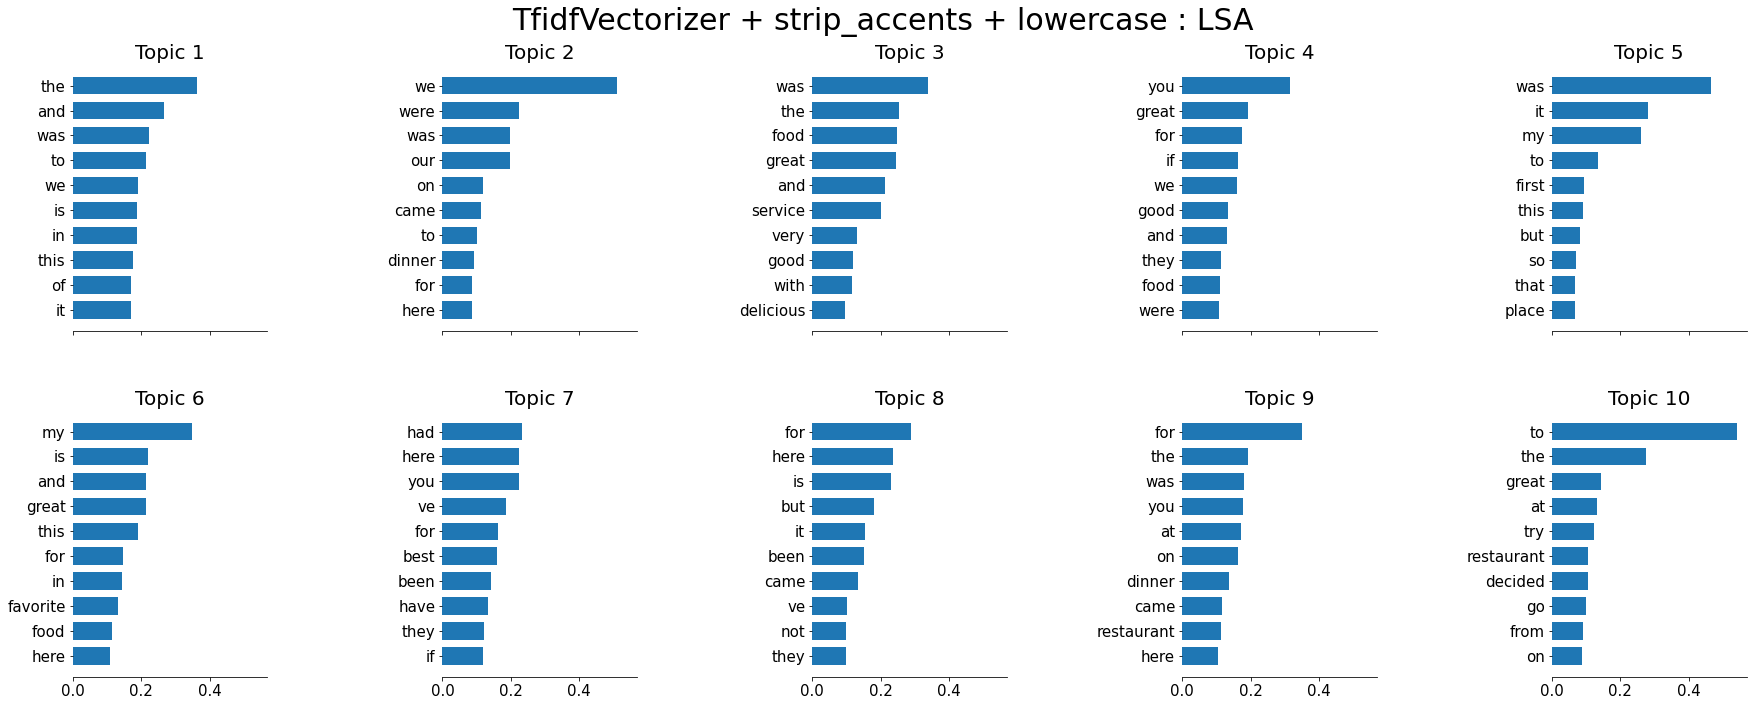

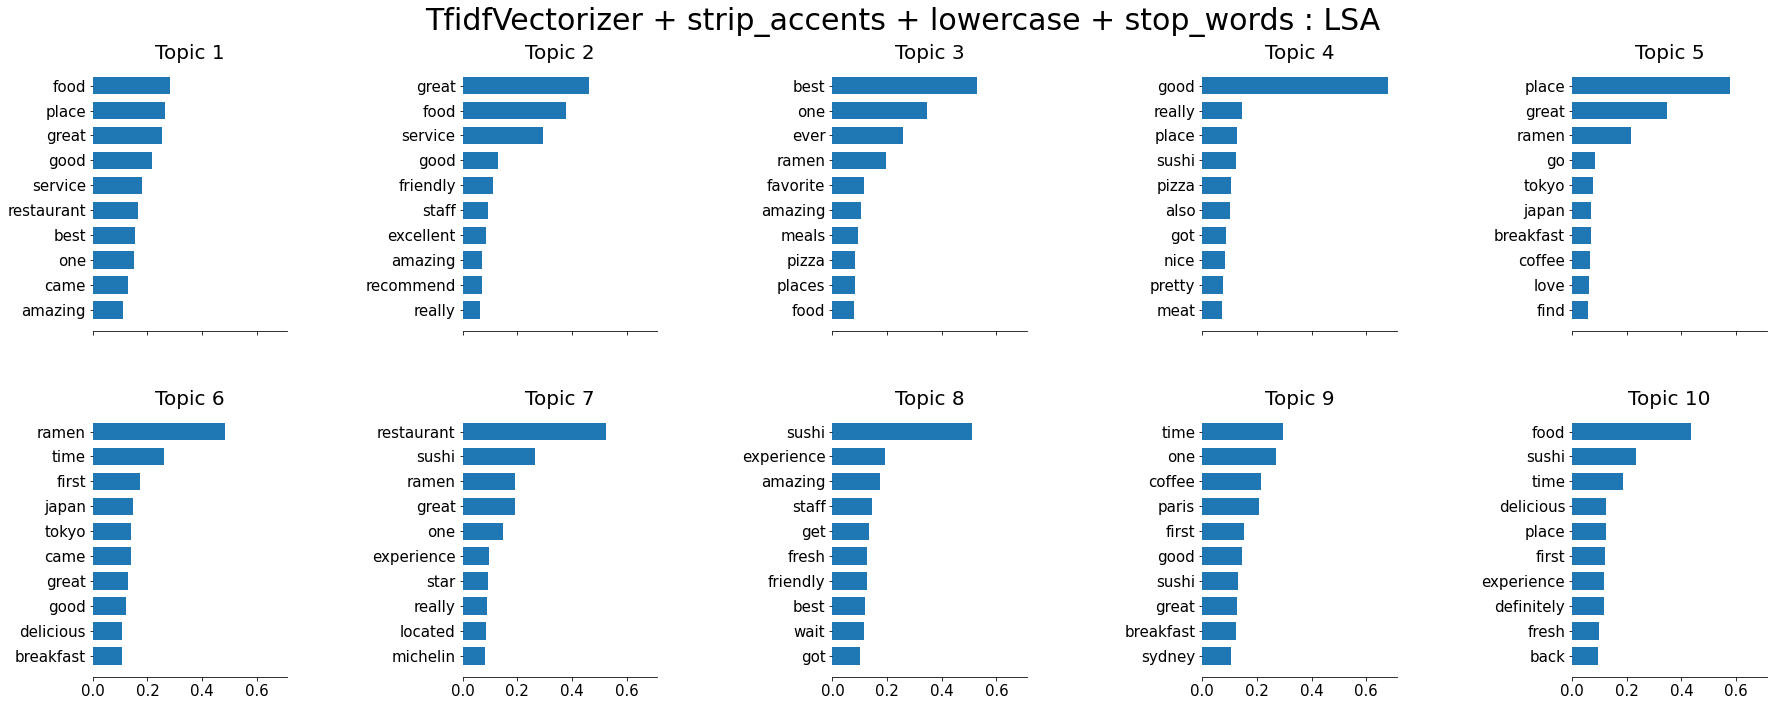

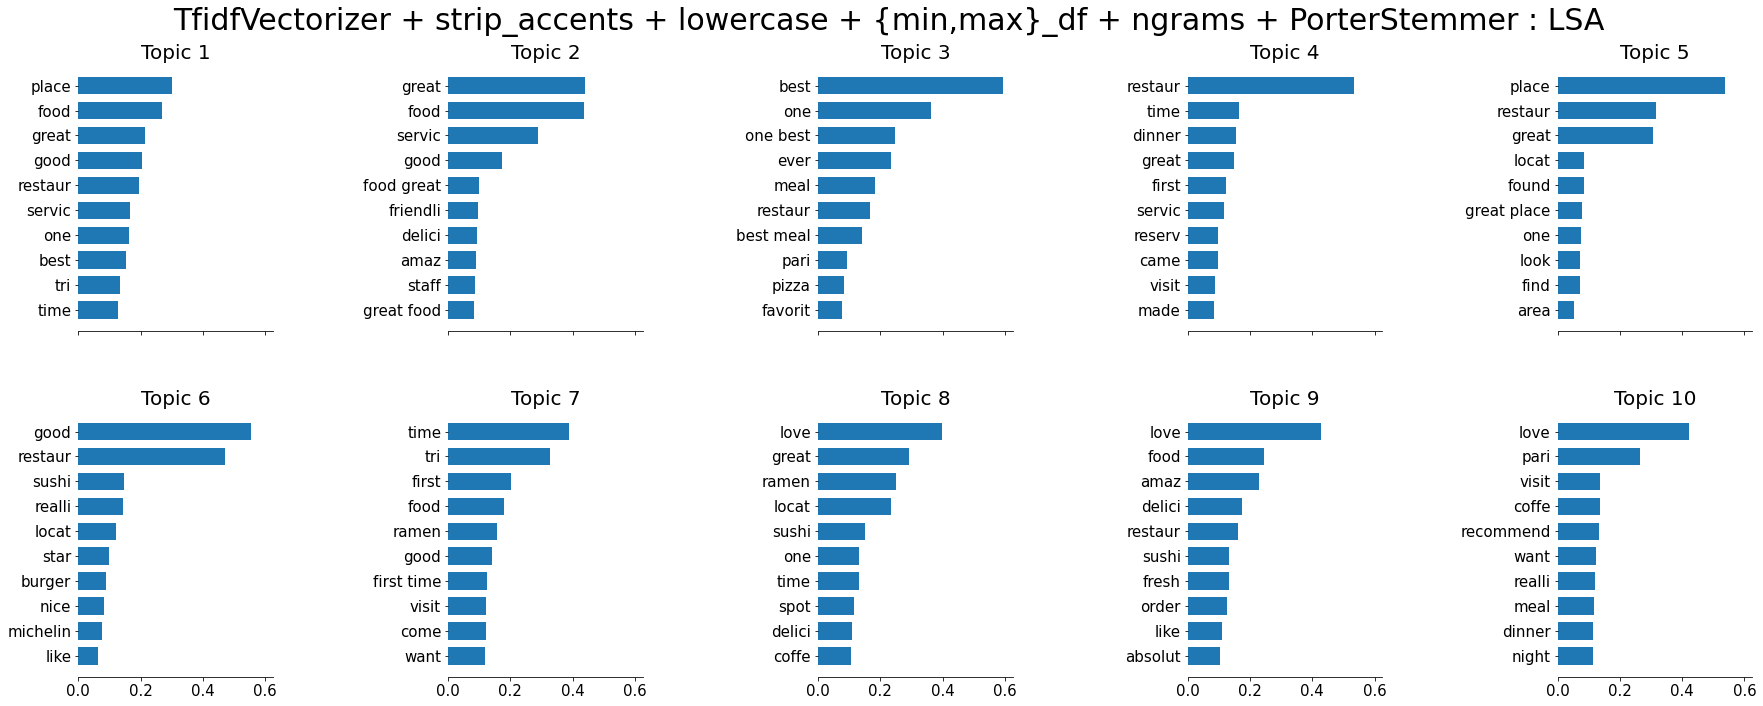

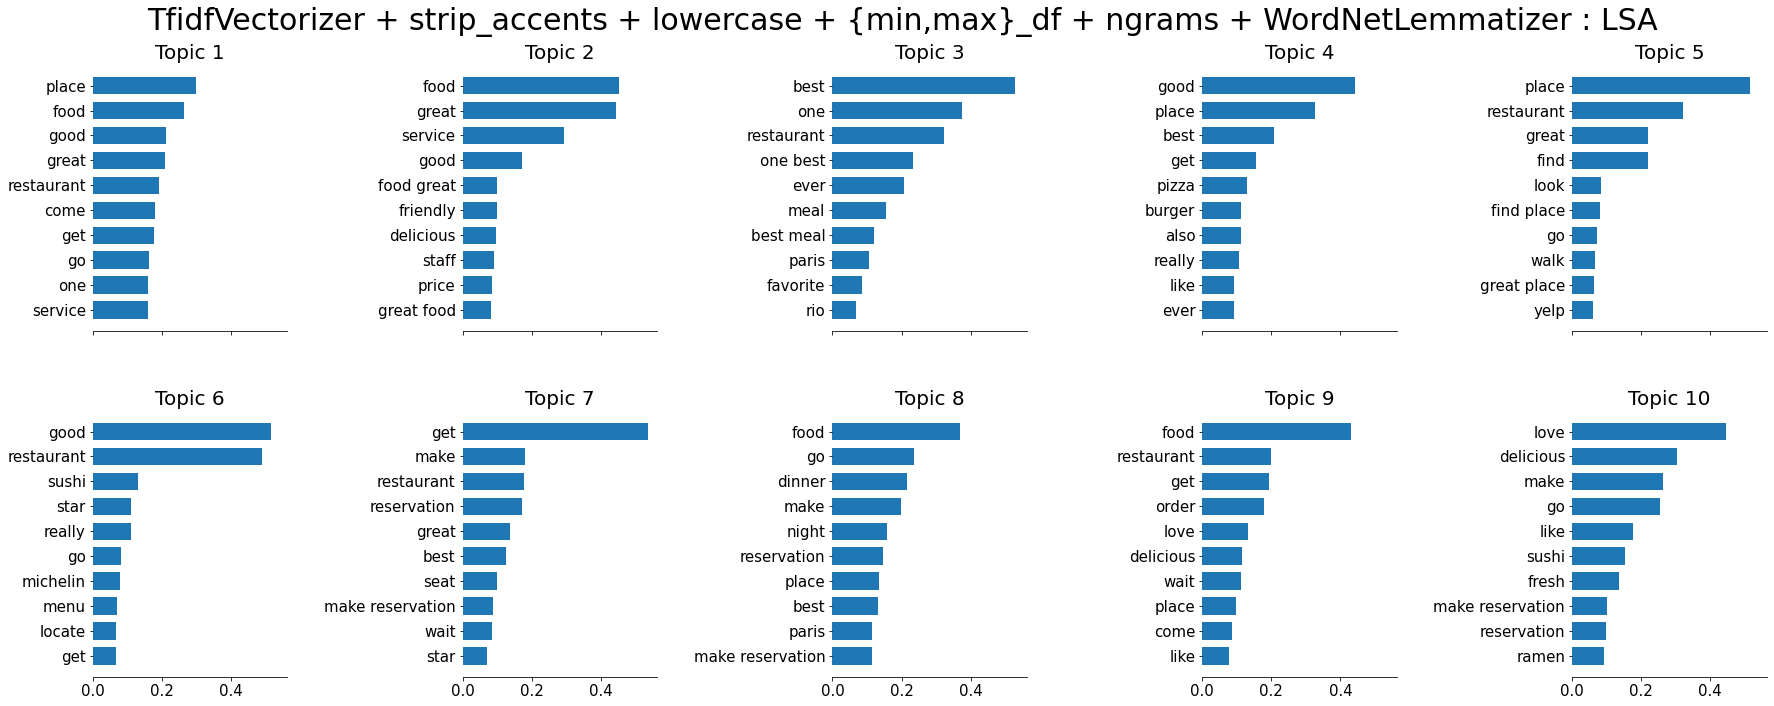

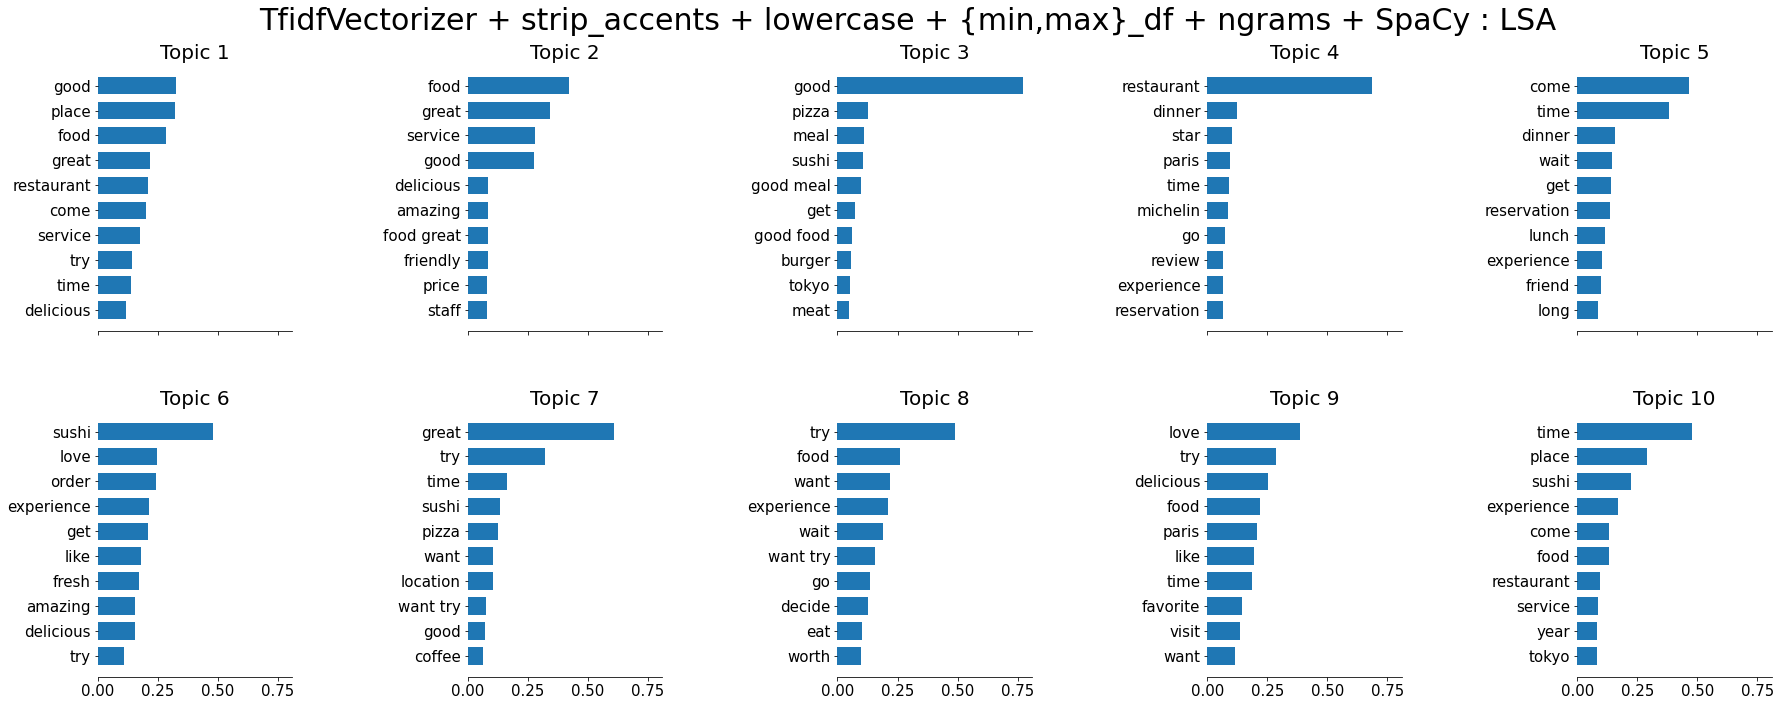

In [72]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation


def plot_top_words(model, feature_names, n_top_words, n_topics, title):
    n_cols = 5
    n_lines = int(np.ceil(min(n_topics, model.n_components) / n_cols))
    fig, axes = plt.subplots(n_lines, n_cols, figsize=(30, 10), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_[0:n_topics]):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=15)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=30)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()


n_components = 100
for vectorizer_name in [
    "TfidfVectorizer + strip_accents + lowercase",
    "TfidfVectorizer + strip_accents + lowercase + stop_words",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + stopwords",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + PorterStemmer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + WordNetLemmatizer",
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy",
]:
    vectorizer = vectorizers[vectorizer_name]
    X_vec = vectorizer.fit_transform(X)

    words_count = pd.Series(
        X_vec.sum(axis=0).tolist()[0],
        index=vectorizer.get_feature_names(),
    )

    top_20_count = words_count.sort_values(ascending=False).head(20)

    fig = px.bar(
        top_20_count,
        x=top_20_count.index,
        y=top_20_count.values,
        labels={"x": "Word", "y": "Count"},
        title=f"{vectorizer_name} : Top 20 frequent words in reviews (vocabulary = {len(words_count)} words)",
        color=top_20_count.values,
    )
    fig.show()

    lsa = TruncatedSVD(n_components=n_components, random_state=42)
    X_lsa = lsa.fit_transform(X_vec)

    fig = px.line(
        x=range(1, n_components + 1),
        y=np.cumsum(lsa.explained_variance_ratio_),
        labels={
            "x": "Principal Component",
            "y": "Explained Variance Ratio",
        },
        title=f"{vectorizer_name} : Explained Variance Ratio",
    )
    fig.show()

    fig = px.scatter_3d(
        X_lsa,
        x=X_lsa[:, 0],
        y=X_lsa[:, 1],
        z=X_lsa[:, 2],
        labels={"x": "Component 1", "y": "Component 2", "z": "Component 3"},
        title=f"{vectorizer_name} : SVD",
        color=y,
        opacity=0.5,
    )
    fig.show()

    plot_top_words(
        model=lsa,
        feature_names=vectorizer.get_feature_names(),
        n_top_words=10,
        n_topics=10,
        title=f"{vectorizer_name} : LSA",
    )


In [73]:
import pyLDAvis
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()


vectorizer = vectorizers[
    "TfidfVectorizer + strip_accents + lowercase + {min,max}_df + ngrams + SpaCy"
]
X_vec = vectorizer.fit_transform(X)

lda = LatentDirichletAllocation(
    n_components=n_components,
    random_state=42,
    n_jobs=-1,
).fit(X_vec)

pyLDAvis.sklearn.prepare(lda, X_vec, vectorizer)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
11     0.104183  0.010526       1        1  1.683477
98     0.027894  0.007343       2        1  1.633691
96     0.100640  0.143026       3        1  1.627863
63    -0.171962  0.024848       4        1  1.612872
31    -0.072064  0.111746       5        1  1.540384
...         ...       ...     ...      ...       ...
34    -0.102576  0.023540      96        1  0.513984
71     0.060762 -0.085867      97        1  0.512489
52    -0.114485 -0.061261      98        1  0.510558
58     0.034997 -0.170640      99        1  0.508252
0     -0.097309 -0.091042     100        1  0.462724

[100 rows x 5 columns], topic_info=           Term       Freq      Total  Category  logprob  loglift
134        menu  55.000000  55.000000   Default  30.0000  30.0000
62   experience  57.000000  57.000000   Default  29.0000  29.0000
206       sushi  50.000000  50.000000   Default  28.0000  28.0000
196        star  47.000000  47.000000   Default  27.0000  27.0000
128        love  63.000000  63.000000   Default  26.0000  26.0000
..          ...        ...        ...       ...      ...      ...
18          big   0.016647  18.152179  Topic100  -7.6063  -1.6185
19          bit   0.016647  30.274294  Topic100  -7.6063  -2.1300
20        bread   0.016647  15.784631  Topic100  -7.6063  -1.4787
21    breakfast   0.016647  33.421501  Topic100  -7.6063  -2.2289
22       brunch   0.016647  29.935102  Topic100  -7.6063  -2.1187

[4463 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0        69  0.958729        able
1        19  0.885605  absolutely
1        29  0.044280  absolutely
2         3  0.031972     amazing
2         6  0.031972     amazing
...     ...       ...         ...
238      10  0.935618         wow
239       3  0.894035        year
239      42  0.061658        year
240       9  0.889033        yelp
240      22  0.074086        yelp

[1284 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 99, 97, 64, 32, 55, 94, 2, 75, 9, 11, 10, 68, 8, 36, 20, 34, 100, 18, 96, 47, 91, 19, 67, 79, 60, 25, 51, 45, 80, 41, 88, 6, 30, 76, 27, 39, 92, 74, 65, 61, 58, 93, 83, 31, 56, 81, 95, 57, 52, 54, 13, 4, 43, 44, 28, 62, 29, 38, 3, 40, 90, 71, 48, 22, 17, 42, 5, 84, 23, 85, 66, 16, 70, 73, 15, 63, 14, 69, 37, 46, 77, 7, 49, 89, 98, 78, 26, 24, 33, 50, 86, 82, 21, 87, 35, 72, 53, 59, 1])

#### Gensim LDA


In [43]:
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary


docs = X.map(tokenizers["SpaCy"])
dictionary = Dictionary(docs)
corpus = [dictionary.doc2bow(doc) for doc in docs]

results_lda = []
for num_topics in range(5, 200, 5):
    lda = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        per_word_topics=True,
        passes=10,
        random_state=42,
    )

    results = {
        "num_topics": num_topics,
        "perplexity": lda.log_perplexity(corpus), # Compute Perplexity (lower is better)
        "coherence": CoherenceModel(lda, texts=docs).get_coherence(),# Compute Coherence Score (higher is better)
    }
    results_lda.append(results)


# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["perplexity"],
        name="Perplexity",
        mode="lines",
    ),
    secondary_y=False,
)
fig.add_trace(
    go.Scatter(
        x=pd.DataFrame(results_lda)["num_topics"],
        y=pd.DataFrame(results_lda)["coherence"],
        name="Coherence",
        mode="lines",
    ),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="LDA Coherence and Perplexity",
    xaxis_title="Number of Topics",
    yaxis_title="Perplexity",
    yaxis2_title="Coherence",
)
fig.show()


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/scipy/sparse/sparsetools.py:21: DeprecationWarning:

`scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.



In [74]:
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

lda = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=n_components,
    per_word_topics=True,
    passes=10,
    random_state=42,
)

pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
58    -0.057077 -0.089266       1        1  2.037685
30    -0.108119 -0.020915       2        1  1.582620
11    -0.178487  0.014457       3        1  1.553815
24    -0.139975 -0.009216       4        1  1.544928
27    -0.187889  0.077410       5        1  1.535603
...         ...       ...     ...      ...       ...
16     0.092822  0.117032      96        1  0.589430
43     0.030663 -0.000886      97        1  0.535871
38    -0.006538 -0.067765      98        1  0.531103
44     0.107860  0.118522      99        1  0.516987
90     0.141954  0.061587     100        1  0.516304

[100 rows x 5 columns], topic_info=       Term        Freq       Total  Category  logprob  loglift
168     day  124.000000  124.000000   Default  30.0000  30.0000
6    review  138.000000  138.000000   Default  29.0000  29.0000
17     good  704.000000  704.000000   Default  28.0000  28.0000
640   pizza  136.000000  136.000000   Default  27.0000  27.0000
594  coffee  104.000000  104.000000   Default  26.0000  26.0000
..      ...         ...         ...       ...      ...      ...
21    place    2.336687  750.993625  Topic100  -4.4035  -0.5064
824    feel    1.352462   79.453761  Topic100  -4.9503   1.1930
39     long    1.159584   77.537500  Topic100  -5.1042   1.0635
296   right    1.159605   97.732128  Topic100  -5.1042   0.8321
142    love    1.147809  193.863884  Topic100  -5.1144   0.1369

[4930 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2783     50  0.633483       aa
2186     60  0.690919       ab
642       3  0.819343  ability
286       1  0.241224     able
286       7  0.090459     able
...     ...       ...      ...
657      66  0.661592  zimmern
1496      7  0.649191   zombie
3767     67  0.903336        à
3891     74  0.632266        é
3223     69  0.458348    神田まつや

[7114 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[59, 31, 12, 25, 28, 56, 52, 89, 37, 50, 16, 72, 94, 18, 42, 70, 19, 79, 93, 51, 21, 65, 3, 40, 24, 81, 23, 26, 6, 66, 82, 75, 64, 35, 38, 9, 100, 96, 71, 60, 84, 83, 53, 99, 1, 54, 2, 27, 14, 11, 48, 22, 88, 20, 90, 49, 85, 87, 76, 34, 69, 63, 36, 55, 33, 78, 57, 30, 32, 98, 10, 7, 74, 73, 97, 95, 8, 5, 67, 13, 77, 4, 61, 80, 43, 47, 15, 41, 86, 92, 62, 68, 29, 46, 58, 17, 44, 39, 45, 91])

In [75]:
from gensim.models import HdpModel


hdp = HdpModel(
    corpus=corpus,
    id2word=dictionary,
    # T=n_components, # Maximum number of topics
    random_state=42,
)

pyLDAvis.gensim_models.prepare(hdp, corpus, dictionary)


/home/clement/Workspace/oc_p6/env/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.001359  0.016444       1        1  4.942430
13     0.005773  0.013957       2        1  3.666999
55     0.014283  0.002479       3        1  3.170918
2      0.016825 -0.004298       4        1  2.770190
3      0.010997 -0.003438       5        1  2.679173
...         ...       ...     ...      ...       ...
135   -0.001113  0.014617     146        1  0.082584
137   -0.000290  0.014658     147        1  0.076497
147   -0.006929 -0.008509     148        1  0.074345
126   -0.000485 -0.003231     149        1  0.049611
138    0.013809  0.014231     150        1  0.031544

[150 rows x 5 columns], topic_info=             Term       Freq      Total  Category  logprob  loglift
21          place  32.000000  32.000000   Default  30.0000  30.0000
111         great  26.000000  26.000000   Default  29.0000  29.0000
482   exceptional   9.000000   9.000000   Default  28.0000  28.0000
15           food  33.000000  33.000000   Default  27.0000  27.0000
930         musée   9.000000   9.000000   Default  26.0000  26.0000
...           ...        ...        ...       ...      ...      ...
4462       peking   0.012995   8.245272  Topic150  -6.8002   1.6087
3407        curve   0.013870   9.101907  Topic150  -6.7350   1.5750
1333      hostess   0.012908   8.510234  Topic150  -6.8068   1.5704
1616       awhile   0.011795   7.670120  Topic150  -6.8970   1.5842
2243          pho   0.012394   8.921810  Topic150  -6.8475   1.4825

[5879 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2186      6  0.256028          ab
5042      1  0.129483     abalone
5042      3  0.129483     abalone
4446     10  0.149925    absinthe
556       3  0.103037  absolutely
...     ...       ...         ...
1545      1  0.230659        yuzu
1545      2  0.115330        yuzu
3459      7  0.144136        zero
1496      3  0.130678      zombie
3969      4  0.161972        zona

[3666 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 14, 56, 3, 4, 5, 103, 57, 39, 1, 8, 70, 101, 21, 10, 47, 77, 52, 32, 2, 51, 30, 115, 13, 43, 69, 78, 132, 27, 105, 41, 16, 25, 40, 6, 85, 73, 44, 65, 63, 82, 71, 99, 75, 24, 35, 58, 33, 59, 36, 55, 124, 86, 9, 76, 29, 22, 81, 38, 7, 74, 11, 42, 72, 87, 54, 26, 79, 31, 60, 92, 64, 102, 128, 19, 93, 111, 12, 142, 68, 141, 48, 53, 61, 88, 45, 129, 108, 116, 20, 104, 37, 133, 46, 89, 110, 34, 143, 144, 98, 137, 117, 23, 15, 83, 91, 17, 84, 109, 120, 107, 49, 66, 149, 97, 67, 62, 95, 147, 112, 90, 135, 18, 113, 123, 118, 106, 80, 96, 145, 100, 126, 125, 140, 146, 134, 130, 150, 94, 50, 122, 119, 121, 114, 131, 136, 138, 148, 127, 139])

### Word Embedding


In [76]:
from gensim.models.word2vec import Word2Vec


word2vec = Word2Vec(docs)
word2vec.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


[('french', 0.999337375164032),
 ('decide', 0.9993358254432678),
 ('table', 0.9993183612823486),
 ('start', 0.999309241771698),
 ('nyc', 0.9993076920509338),
 ('spot', 0.9993070960044861),
 ('experience', 0.999302864074707),
 ('get', 0.9992940425872803),
 ('place', 0.9992885589599609),
 ('cook', 0.999286413192749),
 ('excellent', 0.9992862939834595),
 ('try', 0.9992676377296448),
 ('meal', 0.9992654919624329),
 ('find', 0.9992619156837463),
 ('dinner', 0.9992611408233643),
 ('bit', 0.999256432056427),
 ('pork', 0.999255359172821),
 ('paris', 0.9992538690567017),
 ('restaurant', 0.9992521405220032),
 ('locate', 0.9992510080337524)]

In [77]:
from sklearn.manifold import TSNE


X_w2v = [word2vec.wv[x] for x in word2vec.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=word2vec.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="Word2Vec TSNE",
)
fig.show()


### Fasttext


In [78]:
from gensim.models.fasttext import FastText


fasttext = FastText(docs)
fasttext.wv.most_similar(["sushi", "rio"], ["tokyo"], topn=20)


[('super', 0.9999394416809082),
 ('butter', 0.9999368190765381),
 ('choice', 0.9999348521232605),
 ('lobster', 0.999934732913971),
 ('diner', 0.9999339580535889),
 ('knowledgeable', 0.9999336004257202),
 ('affordable', 0.9999335408210754),
 ('later', 0.999932587146759),
 ('fantastic', 0.9999323487281799),
 ('reasonable', 0.9999322295188904),
 ('charming', 0.9999322295188904),
 ('notice', 0.9999321699142456),
 ('ingredient', 0.9999321103096008),
 ('cheese', 0.9999316930770874),
 ('flavorful', 0.9999314546585083),
 ('counter', 0.9999308586120605),
 ('break', 0.999930739402771),
 ('chinese', 0.999930739402771),
 ('actually', 0.9999306201934814),
 ('honestly', 0.9999306201934814)]

In [79]:
from sklearn.manifold import TSNE


X_w2v = [fasttext.wv[x] for x in fasttext.wv.key_to_index.keys()]
X_tsne = TSNE().fit_transform(X_w2v)

fig = px.scatter(
    x=X_tsne[:, 0],
    y=X_tsne[:, 1],
    text=fasttext.wv.key_to_index.keys(),
    labels={"x": "Component 1", "y": "Component 2"},
    title="FastText TSNE",
)
fig.show()


## Photos


In [16]:
img_path = os.path.join("../data/raw/photos", photos_df["file_name"].values[0])



In [17]:
from PIL import Image

# Charger l'image
img = Image.open(img_path) 

# Afficher l'image chargée
img.show()

# Récupérer et afficher la taille de l'image (en pixels)
w, h = img.size
print("Largeur : {} px, hauteur : {} px".format(w, h))

# Afficher son mode de quantification
print("Format des pixels : {}".format(img.mode))

# Récupérer et afficher la valeur du pixel à une position précise
px_value = img.getpixel((20,100))
print("Valeur du pixel situé en (20,100) : {}".format(px_value))

import numpy as np

# Récupérer les valeurs de tous les pixels sous forme d'une matrice
mat = np.array(img)
print(mat)

# Afficher la taille de la matrice de pixels
print("Taille de la matrice de pixels : {}".format(mat.shape))

Largeur : 1000 px, hauteur : 666 px
Format des pixels : RGB
Valeur du pixel situé en (20,100) : (218, 109, 68)
[[[ 42  15   4]
  [ 43  16   5]
  [ 44  17   6]
  ...
  [ 23   9  26]
  [ 24   7  25]
  [ 27   8  27]]

 [[ 44  18   5]
  [ 46  18   6]
  [ 47  19   7]
  ...
  [ 26   9  28]
  [ 27   8  28]
  [ 29  10  29]]

 [[ 47  17   6]
  [ 48  18   7]
  [ 50  20   9]
  ...
  [ 30   8  31]
  [ 31   9  32]
  [ 35  11  33]]

 ...

 [[214 116  87]
  [211 113  86]
  [202 107  79]
  ...
  [202 171 187]
  [199 166 183]
  [195 161 178]]

 [[195  96  65]
  [190  91  62]
  [201 102  73]
  ...
  [199 166 183]
  [194 160 177]
  [192 155 173]]

 [[201  97  68]
  [192  91  63]
  [201 100  72]
  ...
  [196 162 178]
  [192 155 172]
  [188 149 168]]]
Taille de la matrice de pixels : (666, 1000, 3)


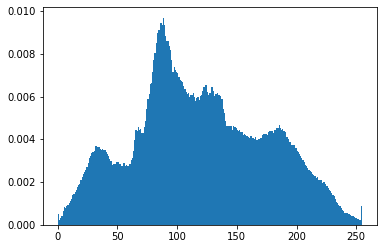

In [51]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Charger l'image comme matrice de pixels
img = np.array(Image.open(img_path))

# Générer et afficher l'histogramme
# Pour le normaliser : argument density=True dans plt.hist
# Pour avoir l'histogramme cumulé : argument cumulative=True
n, bins, patches = plt.hist(img.flatten(), bins=range(256), density=True)
plt.show()

In [19]:
# Charger l'image sous forme d'une matrice de pixels
img = Image.open(img_path)


from PIL import ImageFilter

# Appliquer le lissage par moyennage (fenêtre de taille 9) et afficher le résultat
img.filter(ImageFilter.BoxBlur(10)).show()

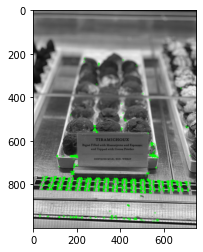

Number of keypoints detected:  2000


In [48]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


photo = photos_df.sample(1).iloc[0]
img_path = os.path.join("../data/raw/photos", photo["file_name"])


img = cv.imread(img_path, flags=cv.IMREAD_GRAYSCALE)

orb = cv.ORB_create(nfeatures=2000)
kp, des = orb.detectAndCompute(img, None)

kp_img = cv.drawKeypoints(img, kp, None, color=(0, 255, 0), flags=0)

plt.imshow(kp_img)
plt.show()


print("Number of keypoints detected: ", len(kp))


In [21]:

from skimage.feature import local_binary_pattern


# Compute the Local Binary Pattern representation
lbp = local_binary_pattern(img, P=8, R=1)


# Display the image
plt.imshow(lbp, cmap="gray")
plt.show()





ValueError: The parameter `image` must be a 2-dimensional array

In [ ]:
photo = photos_df.sample().iloc[0]

photo

business_alias                                  le-petit-cler-paris
photo_url         https://s3-media2.fl.yelpcdn.com/bphoto/8j4Vhi...
file_name         le-petit-cler-paris_b06df42ebea867927cec5ba39e...
Name: 38, dtype: string

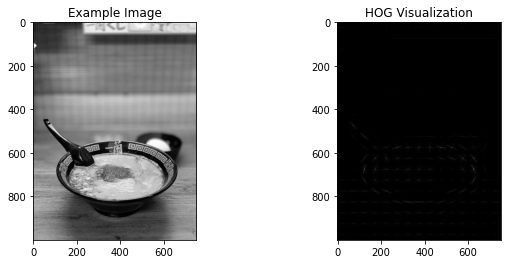

In [ ]:
from skimage.feature import hog



photo = photos_df.sample().iloc[0]
img_path = os.path.join("../data/raw/photos", photo["file_name"])
img = cv.imread(img_path, 0)


# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(
            img,
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=True,
            visualize=vis,
            feature_vector=feature_vec,
        )
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(
            img,
            orientations=orient,
            pixels_per_cell=(pix_per_cell, pix_per_cell),
            cells_per_block=(cell_per_block, cell_per_block),
            transform_sqrt=True,
            visualize=vis,
            feature_vector=feature_vec,
        )
        return features


# Define parameters for HOG descriptor
orient = 9
pix_per_cell = 50
cell_per_block = 2


# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(
    img, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True
)


# Plot the examples
fig = plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.imshow(img, cmap="gray")
plt.title("Example Image")
plt.subplot(122)
plt.imshow(hog_image, cmap="gray")
plt.title("HOG Visualization")
plt.show()




In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt


nfeatures = 200
orb_photos_desc_df = pd.DataFrame(columns=[f"ORB_{i}" for i in range(0, 32 * nfeatures)])

for photo in photos_df.itertuples():
    img_path = os.path.join("../data/raw/photos", photo.file_name)
    img = cv.imread(img_path, 0)

    # Initiate ORB detector
    orb = cv.ORB_create(nfeatures=nfeatures)

    # find the keypoints with ORB
    kp = orb.detect(img, None)

    # compute the descriptors with ORB
    kp, des = orb.compute(img, kp)

    # Append the descriptors to the dataframe
    if des is not None:
        orb_photos_desc_df.loc[photo.file_name] = des.flatten()


orb_photos_desc_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 999 entries, le-comptoir-de-la-gastronomie-paris_0200c0c54c8e4c03367d78a0bf238bd2.jpg to harts-pub-the-rocks-2_af6c192e2e07a42c2bbabb4030e9006d.jpg
Columns: 6400 entries, ORB_0 to ORB_6399
dtypes: object(6400)
memory usage: 48.8+ MB


### Global features


(1296,)

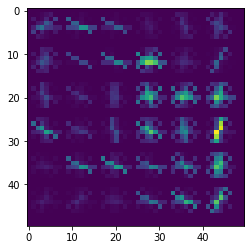

In [508]:
from skimage.feature import hog
import cv2 as cv


photo = photos_df.iloc[2]

img_path = os.path.join("../data/raw/photos", photo.file_name)
img = cv.imread(img_path, flags=cv.IMREAD_COLOR)
img = cv.resize(img, (50,50))

desc, hog_img = hog(img, visualize=True, multichannel=True)
# plt.imshow(img)
plt.imshow(hog_img)
desc.shape


In [283]:
from skimage.feature import hog
import cv2 as cv



sizes = [2, 3, 5, 8, 13, 21]
size_photos_desc_df = pd.DataFrame(
    columns=[
        f"{size}_{color}_{i}_{j}"
        for size in sizes
        for color in ["red", "green", "blue", "hue", "saturation", "value", "lightness", "a", "b"]
        for j in range(0, size)
        for i in range(0, size)
    ]
)

for photo in photos_df.itertuples():
    img_path = os.path.join("../data/raw/photos", photo.file_name)
    img = cv.imread(img_path, flags=cv.IMREAD_COLOR)

    # desc = hog(img)

    desc=[]
    for size in sizes:
        img_res = cv.resize(img, (size, size))

        img_rgb = cv.cvtColor(img_res, cv.COLOR_BGR2RGB)
        red = img_rgb[:, :, 0].flatten()
        green = img_rgb[:, :, 1].flatten()
        blue = img_rgb[:, :, 2].flatten()

        img_hsv = cv.cvtColor(img_res, cv.COLOR_BGR2HSV)
        hue = img_hsv[:, :, 0].flatten()
        saturation = img_hsv[:, :, 1].flatten()
        value = img_hsv[:, :, 2].flatten()

        img_lab = cv.cvtColor(img_res, cv.COLOR_BGR2LAB)
        lightness = img_lab[:, :, 0].flatten()
        a = img_lab[:, :, 1].flatten()
        b = img_lab[:, :, 2].flatten()

        desc = np.concatenate(
            (desc, red, green, blue, hue, saturation, value, lightness, a, b)
        )

    size_photos_desc_df.loc[photo.file_name] = desc


size_photos_desc_df.describe()


2_red_0_0   2_red_1_0   2_red_0_1   2_red_1_1  2_green_0_0  \
count  999.000000  999.000000  999.000000  999.000000   999.000000   
mean   144.000000  140.318318  140.923924  140.845846   118.814815   
std     72.799433   73.120681   70.311476   73.090716    70.968725   
min      0.000000    0.000000    0.000000    0.000000     0.000000   
25%     81.500000   75.000000   83.000000   77.000000    58.000000   
50%    155.000000  152.000000  150.000000  151.000000   118.000000   
75%    207.000000  204.000000  202.500000  206.000000   178.000000   
max    255.000000  255.000000  255.000000  255.000000   255.000000   

       2_green_1_0  2_green_0_1  2_green_1_1  2_blue_0_0  2_blue_1_0  ...  \
count   999.000000   999.000000   999.000000  999.000000  999.000000  ...   
mean    116.342342   112.512513   113.258258   95.518519   93.992993  ...   
std      70.514534    69.009261    71.288354   71.313847   70.872850  ...   
min       0.000000     0.000000     0.000000    0.000000    0.000000  ...   
25%      51.500000    54.000000    49.000000   32.000000   32.000000  ...   
50%     116.000000   109.000000   110.000000   82.000000   82.000000  ...   
75%     175.000000   169.000000   178.500000  152.000000  148.000000  ...   
max     255.000000   255.000000   255.000000  255.000000  255.000000  ...   

       21_b_11_20  21_b_12_20  21_b_13_20  21_b_14_20  21_b_15_20  21_b_16_20  \
count  999.000000  999.000000  999.000000  999.000000  999.000000  999.000000   
mean   140.573574  140.518519  140.620621  140.537538  140.604605  140.292292   
std     15.951340   16.657441   16.918857   16.335239   16.298162   16.052290   
min     68.000000   49.000000   42.000000   43.000000   45.000000   50.000000   
25%    130.000000  129.500000  129.000000  130.000000  129.000000  130.000000   
50%    138.000000  137.000000  137.000000  138.000000  137.000000  137.000000   
75%    149.000000  149.000000  149.000000  148.000000  149.000000  149.000000   
max    205.000000  200.000000  200.000000  200.000000  202.000000  203.000000   

       21_b_17_20  21_b_18_20  21_b_19_20  21_b_20_20  
count  999.000000  999.000000   999.00000  999.000000  
mean   140.783784  140.774775   140.94995  140.593594  
std     16.070464   15.878116    16.14791   15.692594  
min     58.000000   58.000000    57.00000   79.000000  
25%    130.000000  130.000000   130.00000  130.000000  
50%    138.000000  138.000000   138.00000  137.000000  
75%    150.000000  150.000000   150.00000  150.000000  
max    202.000000  202.000000   204.00000  207.000000  

[8 rows x 6408 columns]

In [284]:
size_photos_desc_df.head()


2_red_0_0  2_red_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...      171.0      134.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       80.0      203.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...      227.0      117.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...      108.0       90.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...      248.0      152.0   

                                                    2_red_0_1  2_red_1_1  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...      103.0      173.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...      193.0       22.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       69.0      179.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...      116.0      225.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...      234.0      182.0   

                                                    2_green_0_0  2_green_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...         91.0         32.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...        127.0        203.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...        183.0        121.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...         99.0         90.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...        209.0         79.0   

                                                    2_green_0_1  2_green_1_1  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...         28.0        115.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...        131.0         23.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...         51.0        123.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...        103.0        187.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...        169.0        156.0   

                                                    2_blue_0_0  2_blue_1_0  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...        87.0        17.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       109.0       195.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       108.0       132.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...        92.0        66.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       130.0        55.0   

                                                    ...  21_b_11_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...  ...       131.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...  ...       134.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...  ...       136.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...  ...       138.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...  ...       153.0   

                                                    21_b_12_20  21_b_13_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       137.0       128.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       129.0       126.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       139.0       140.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...       139.0       137.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       153.0       153.0   

                                                    21_b_14_20  21_b_15_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       126.0       135.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       126.0       126.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       130.0       135.0   
l-avant-comptoir-paris-3_73670e8469e59d89b41bfd...       138.0       138.0   
la-coïncidence-paris-4_3b775bee0b2de9e4fa369fb5...       154.0       155.0   

                                                    21_b_16_20  21_b_17_20  \
le-comptoir-de-la-gastronomie-paris_0200c0c54c8...       129.0       125.0   
l-as-du-fallafel-paris_ab3344d5839c2238e825b288...       129.0       131.0   
angelina-paris_0aced3805db4ea7246d49c771fc48d80...       126.0       126.0   
l-avant-comptoir-paris-3_73670

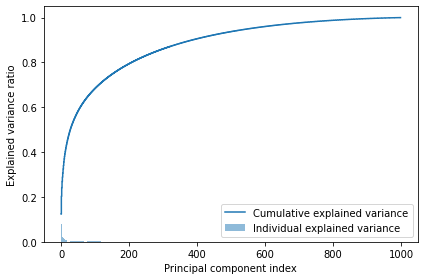

In [400]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

#
# Instantiate PCA
#
pca = PCA()
#
# Determine transformed features
#
pca.fit(StandardScaler().fit_transform(size_photos_desc_df))
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [465]:
import numpy as np
from sklearn.neighbors import NearestNeighbors


pca_size_photos_desc_df = PCA(n_components=10).fit_transform(StandardScaler().fit_transform(size_photos_desc_df))

# Create a nearest neighbor classifier
size_nbrs = NearestNeighbors(n_neighbors=2).fit(
    pca_size_photos_desc_df
)


# Compute the distances between the query image and all images
size_distances, size_indices = size_nbrs.kneighbors(pca_size_photos_desc_df)


In [466]:
fig = go.Figure(
    data=[
        go.Scatter(
            x=pca_size_photos_desc_df[:, 0],
            y=pca_size_photos_desc_df[:, 1],
            mode="markers",
            marker=dict(size=1, opacity=0.5),
        )
    ]
)

for i, photo in enumerate(photos_df.sample(100).itertuples()):
    # Add images
    fig.add_layout_image(
        dict(
            source=photo.photo_url,
            xref="x",
            yref="y",
            x=pca_size_photos_desc_df[i, 0],
            y=pca_size_photos_desc_df[i, 1],
            sizex=10,
            sizey=10,
        )
    )

fig.show()


345


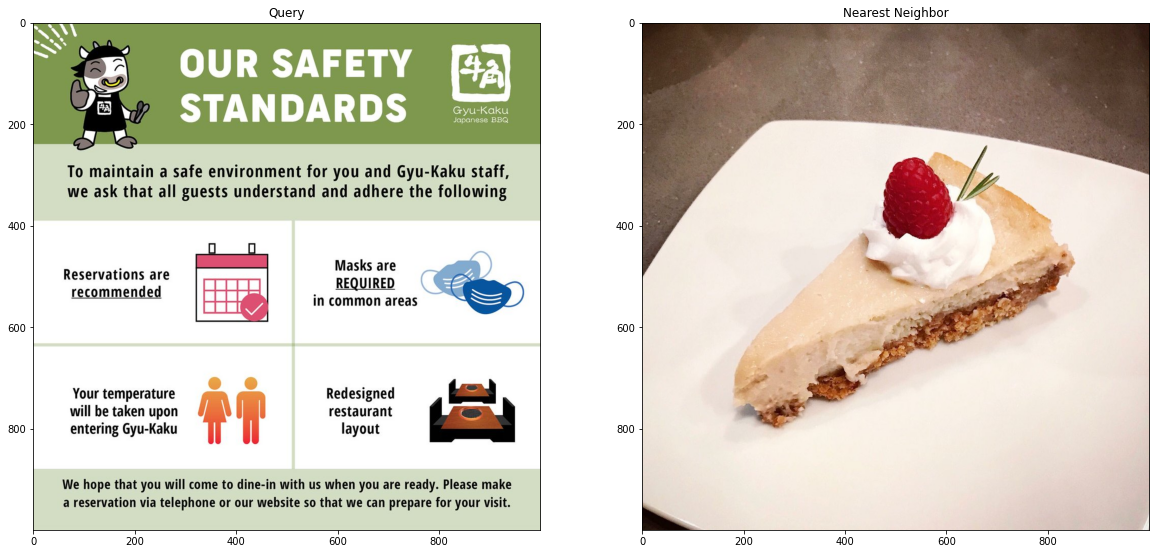

In [482]:
import random


query_index = random.randint(0, len(photos_df) - 1)
print(query_index)
nn_index = size_indices[query_index][1]

query_photo = photos_df.iloc[query_index]
query_img_path = os.path.join("../data/raw/photos", query_photo["file_name"])
query_img = cv.cvtColor(cv.imread(query_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)

nn_photo = photos_df.iloc[nn_index]
nn_img_path = os.path.join("../data/raw/photos", nn_photo["file_name"])
nn_img = cv.cvtColor(cv.imread(nn_img_path, flags=cv.IMREAD_COLOR), cv.COLOR_BGR2RGB)


# Plot the examples
fig = plt.figure(figsize=(20, 15))
plt.subplot(121)
plt.imshow(query_img)
plt.title("Query")
plt.subplot(122)
plt.imshow(nn_img)
plt.title("Nearest Neighbor")
plt.show()
